# Forecasting cryptocurrency returns with artificial neural networks
### Author: Hubert Antoniewicz

Projects present application of machine learning (artifical neural networks) in investment sector. 

This code was attached to my Master's thesis which I wrote about application of machine learning in investment sector

#### Importing packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_datareader as web
import datetime as dt
import numpy as np
import yfinance as yf

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

#### Cryptocurrency choice

In [2]:
crypto = 'ETH'
fiat = 'USD'

#### Date choice for training dataset

In [3]:
start = dt.datetime(2018,1,1)
end = dt.datetime(2021,12,31)

In [4]:
data_ticker = yf.Ticker(f'{crypto}-{fiat}')
data = data_ticker.history(start = start, end = end)

In [5]:
#data = web.DataReader(f'{crypto}-{fiat}', 'yahoo', start,end)

In [6]:
len(data)

1460

### Hurst exponential

In [7]:
def hurst_exponent(time_series, n):    
    lags = range(2,n)
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [8]:
print(hurst_exponent(data["Close"].values, 1000))

0.45087305586149445


### Historical price of underlying

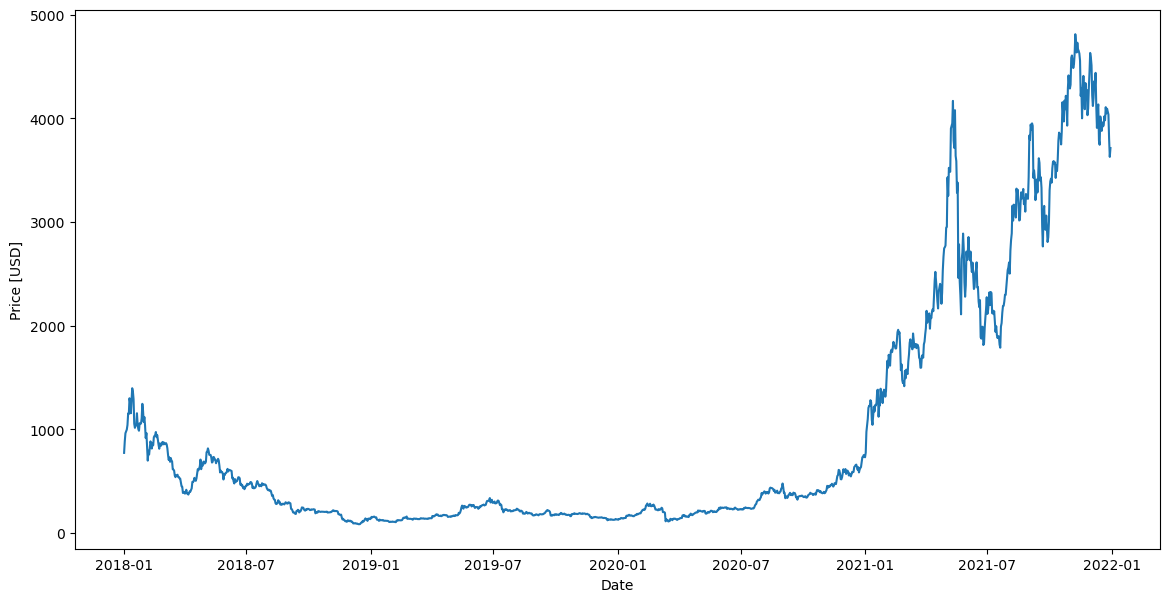

In [9]:
plt.figure(figsize=(14,7))
plt.plot(data.index, data.Close)
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.show()

### Log price chart

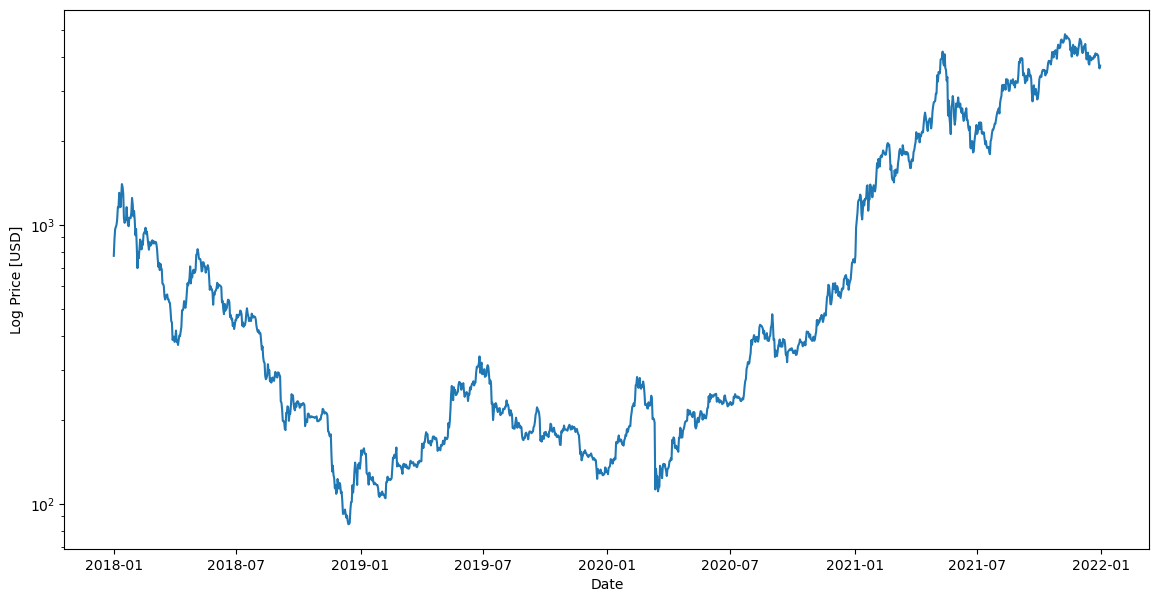

In [10]:
plt.figure(figsize=(14,7))
plt.plot(data.index, data.Close)
plt.xlabel('Date')
plt.ylabel('Log Price [USD]')
plt.yscale('log')
plt.show()

In [11]:
data['Close'].count()

1460

In [12]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-01 00:00:00+00:00,755.757019,782.530029,742.004028,772.640991,2595760128,0.0,0.0
2018-01-02 00:00:00+00:00,772.346008,914.830017,772.346008,884.443970,5783349760,0.0,0.0
2018-01-03 00:00:00+00:00,886.000000,974.471008,868.450989,962.719971,5093159936,0.0,0.0
2018-01-04 00:00:00+00:00,961.713013,1045.079956,946.085999,980.921997,6502859776,0.0,0.0
2018-01-05 00:00:00+00:00,975.750000,1075.390015,956.325012,997.719971,6683149824,0.0,0.0


### Returns analysis

In [13]:
ts = pd.DataFrame(data.Close)

In [14]:
ts['Pct_change'] = ts.Close.pct_change()
ts = ts[ts.index!='2018-01-01']
ts.head()

,Close,Pct_change
Date,,
2018-01-02 00:00:00+00:00,884.443970,0.144702
2018-01-03 00:00:00+00:00,962.719971,0.088503
2018-01-04 00:00:00+00:00,980.921997,0.018907
2018-01-05 00:00:00+00:00,997.719971,0.017125
2018-01-06 00:00:00+00:00,1041.680054,0.044061


### Distribution of returns

In [15]:
ts.Pct_change.mean()*365

0.8805666581087088

In [16]:
ts.Pct_change.std()*np.sqrt(365)

0.9768275000561938

In [17]:
skew(ts.Pct_change, bias = False)

-0.3613682612551179

In [18]:
kurtosis(ts.Pct_change, bias = False)

5.599922818632136

### Returns histogram

/var/folders/xh/5lg9qcnx25b4hk8z8j66l_r80000gn/T/ipykernel_38147/4240201386.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.00%}' for x in plt.gca().get_xticks()])


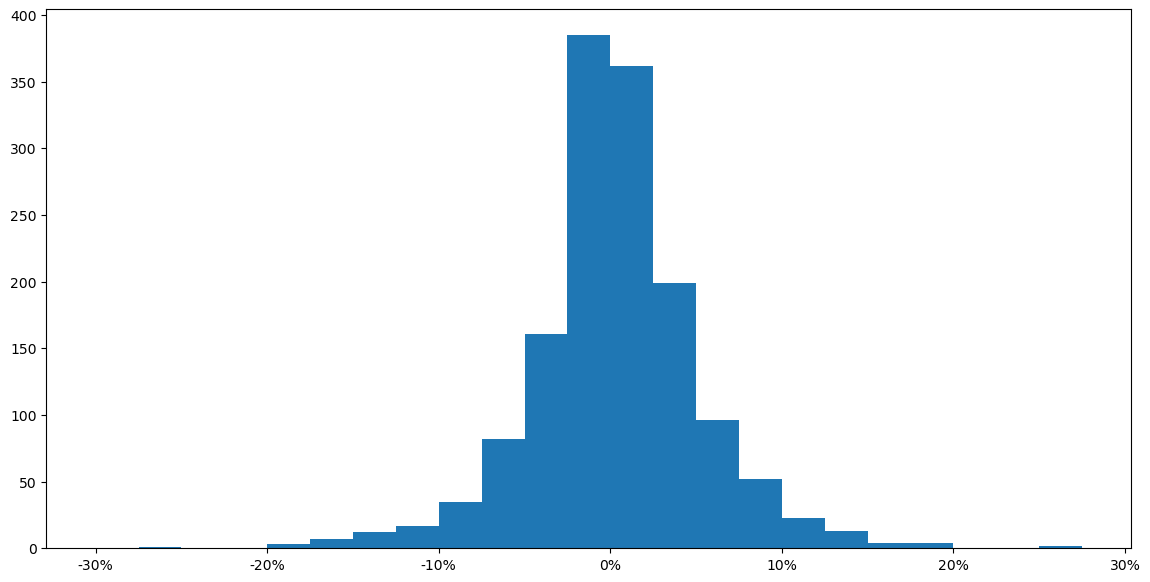

In [19]:
fig, ax = plt.subplots(figsize =(14, 7))
ax.hist(ts.Pct_change, bins = list(list(np.arange(-0.3,0.3,0.025))))
plt.gca().set_xticklabels([f'{x:.00%}' for x in plt.gca().get_xticks()])  
# Show plot
plt.show();

/var/folders/xh/5lg9qcnx25b4hk8z8j66l_r80000gn/T/ipykernel_38147/3513696688.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


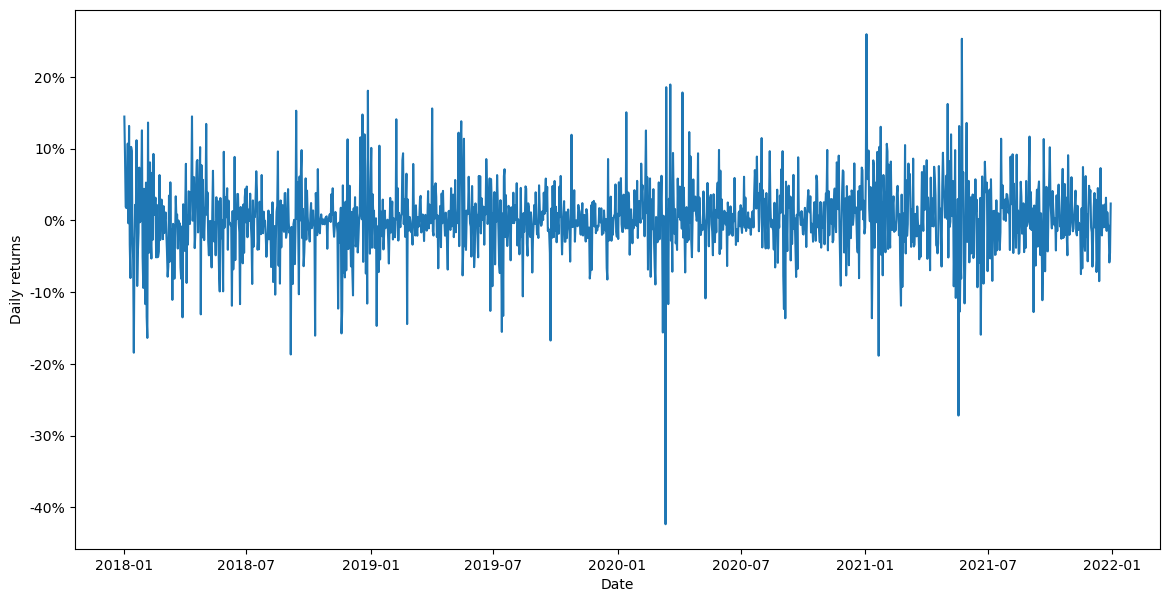

In [20]:
plt.figure(figsize=(14,7))
plt.plot(ts.index, ts.Pct_change)
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.show();

### Preparing data for modelling and forecasting

#### Assumptions:
+ 8 different models,
+ batch = 32,
+ 50 epochs and decreasing if error rate will remain the same
+ forecast window will be chosen for best model

#### Parametry

In [21]:
training_days = 10
prediction_days = 1

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(ts['Close'].values.reshape(-1,1))

In [23]:
x_train, y_train = [], []

for x in range(training_days, len(scaled_data)-prediction_days):
    x_train.append(scaled_data[x-training_days:x, 0])
    y_train.append(scaled_data[x+prediction_days, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#### Error plot 

In [24]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.25))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=50))
model.add(Dropout(0.25))
model.add(Dense(units=1))
model.compile(optimizer ='adam', loss ='mean_squared_error')

In [25]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
46/46 [==============================] - 5s 16ms/step - loss: 0.0271
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0042
Epoch 3/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0042
Epoch 4/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0036
Epoch 5/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0036
Epoch 6/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0039
Epoch 7/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0034
Epoch 8/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0032
Epoch 9/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0034
Epoch 10/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0036
Epoch 11/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0044
Epoch 12/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0033
Epoch 13/50
46/46 [==================

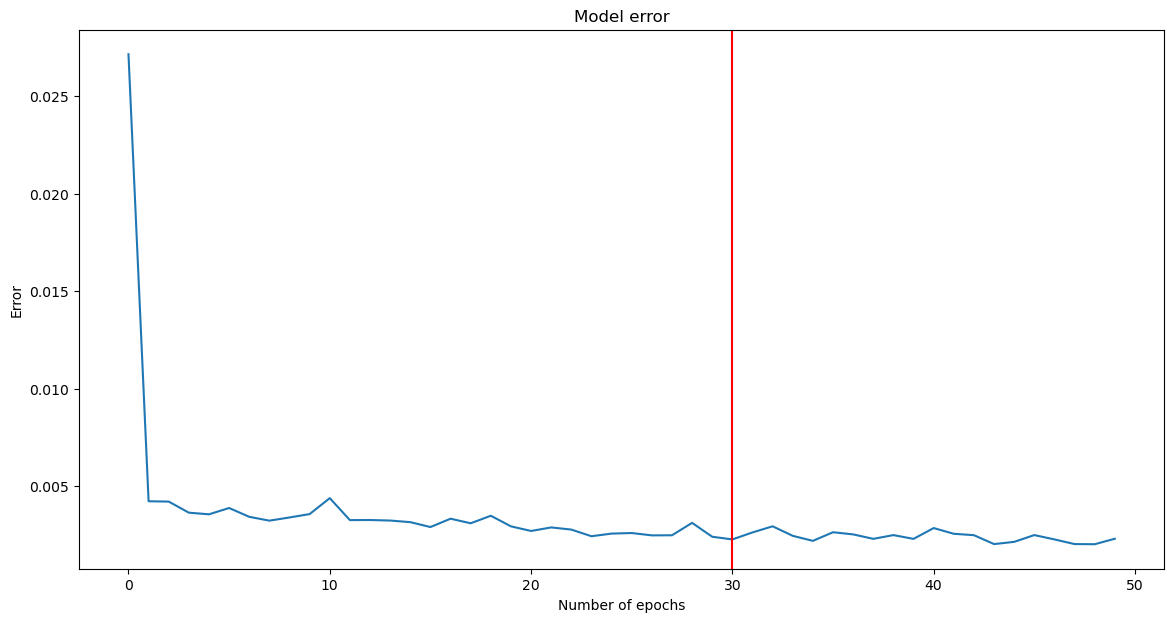

In [26]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'])
plt.title('Model error')
plt.ylabel('Error')
plt.xlabel('Number of epochs')
plt.axvline(x = 30, color = 'r')
plt.show();

In [27]:
model1 = Sequential()
model1.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model1.add(Dropout(0.15))
model1.add(LSTM(units=75, return_sequences=True))
model1.add(Dropout(0.15))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=25))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))
model1.compile(optimizer ='adam', loss ='mean_squared_error')

In [28]:
model2 = Sequential()
model2.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model2.add(Dropout(0.15))
model2.add(LSTM(units=50, return_sequences=True))
model2.add(Dropout(0.15))
model2.add(LSTM(units=50))
model2.add(Dropout(0.15))
model2.add(Dense(units=1))
model2.compile(optimizer ='adam', loss ='mean_squared_error')

In [29]:
model3 = Sequential()
model3.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model3.add(Dropout(0.2))
model3.add(LSTM(units=100, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=100, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=100))
model3.add(Dropout(0.2))
model3.add(Dense(units=1))
model3.compile(optimizer ='adam', loss ='mean_squared_error')

In [30]:
model4 = Sequential()
model4.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model4.add(Dropout(0.1))
model4.add(LSTM(units=20, return_sequences=True))
model4.add(Dropout(0.1))
model4.add(LSTM(units=20, return_sequences=True))
model4.add(Dropout(0.1))
model4.add(LSTM(units=20, return_sequences=True))
model4.add(Dropout(0.1))
model4.add(LSTM(units=20))
model4.add(Dropout(0.1))
model4.add(Dense(units=1))
model4.compile(optimizer ='adam', loss ='mean_squared_error')

In [31]:
model5 = Sequential()
model5.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model5.add(LSTM(units=100))
model5.add(Dense(units=1))
model5.compile(optimizer ='adam', loss ='mean_squared_error')

In [32]:
model6 = Sequential()
model6.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model6.add(LSTM(units=100, return_sequences=True,activation="relu"))
model6.add(LSTM(units=100,activation="relu"))
model6.add(Dense(units=1))
model6.compile(optimizer ='adam', loss ='mean_squared_error')

In [33]:
model7 = Sequential()
model7.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model7.add(LSTM(units=10, return_sequences=True))
model7.add(LSTM(units=10, return_sequences=True))
model7.add(LSTM(units=10))
model7.add(Dense(units=1))
model7.compile(optimizer ='adam', loss ='mean_squared_error')

In [34]:
model8 = Sequential()
model8.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model8.add(Dropout(0.05))
model8.add(LSTM(units=200, return_sequences=True,activation="relu"))
model8.add(Dropout(0.05))
model8.add(LSTM(units=100,activation="relu"))
model8.add(Dense(units=1))
model8.compile(optimizer ='adam', loss ='mean_squared_error')

In [35]:
model9 = Sequential()
model9.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model9.add(LSTM(units=100))
model9.add(Dense(units=1))
model9.compile(optimizer ='adam', loss ='mean_squared_error')

In [36]:
model10 = Sequential()
model10.add(LSTM(units=10, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model10.add(Dropout(0.15))
model10.add(LSTM(units=75, return_sequences=True))
model10.add(Dropout(0.15))
model10.add(LSTM(units=50, return_sequences=True))
model10.add(Dropout(0.2))
model10.add(LSTM(units=25))
model10.add(Dropout(0.2))
model10.add(Dense(units=1))
model10.compile(optimizer ='adam', loss ='mean_squared_error')

In [37]:
model1.fit(x_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
46/46 [==============================] - 3s 10ms/step - loss: 0.0179
Epoch 2/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 3/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0040
Epoch 4/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 5/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 6/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 7/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 8/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 9/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0027
Epoch 10/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 11/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 12/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 13/30
46/46 [==================

In [38]:
model2.fit(x_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
46/46 [==============================] - 3s 7ms/step - loss: 0.0138
Epoch 2/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 3/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 4/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 5/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 6/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 7/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 8/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 9/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 10/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 11/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 12/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 13/30
46/46 [==============================

In [39]:
model3.fit(x_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
46/46 [==============================] - 4s 16ms/step - loss: 0.0177
Epoch 2/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0033
Epoch 3/30
46/46 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 4/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0029
Epoch 5/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0026
Epoch 6/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0025
Epoch 7/30
46/46 [==============================] - 1s 17ms/step - loss: 0.0026
Epoch 8/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0026
Epoch 9/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0026
Epoch 10/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0023
Epoch 11/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0026
Epoch 12/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0022
Epoch 13/30
46/46 [==================

In [40]:
model4.fit(x_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
46/46 [==============================] - 4s 9ms/step - loss: 0.0393
Epoch 2/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 3/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 4/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 5/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 6/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 7/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 8/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0030
Epoch 9/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0030
Epoch 10/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 11/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 12/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 13/30
46/46 [==============================

In [41]:
model5.fit(x_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
46/46 [==============================] - 2s 6ms/step - loss: 0.0122
Epoch 2/30
46/46 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 3/30
46/46 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 4/30
46/46 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 5/30
46/46 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 6/30
46/46 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 7/30
46/46 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 8/30
46/46 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 9/30
46/46 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 10/30
46/46 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 11/30
46/46 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 12/30
46/46 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 13/30
46/46 [==============================

In [42]:
model6.fit(x_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
46/46 [==============================] - 2s 10ms/step - loss: 0.0282
Epoch 2/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 3/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 4/30
46/46 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 5/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 6/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 7/30
46/46 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 8/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 9/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 10/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 11/30
46/46 [==============================] - 1s 11ms/step - loss: 0.0016
Epoch 12/30
46/46 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 13/30
46/46 [==================

In [43]:
model7.fit(x_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
46/46 [==============================] - 4s 16ms/step - loss: 0.0509
Epoch 2/30
46/46 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 3/30
46/46 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 4/30
46/46 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5/30
46/46 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 6/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0019
Epoch 7/30
46/46 [==============================] - 1s 11ms/step - loss: 0.0018
Epoch 8/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0020
Epoch 9/30
46/46 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 10/30
46/46 [==============================] - 1s 15ms/step - loss: 0.0017
Epoch 11/30
46/46 [==============================] - 1s 12ms/step - loss: 0.0019
Epoch 12/30
46/46 [==============================] - 1s 13ms/step - loss: 0.0019
Epoch 13/30
46/46 [=====================

In [44]:
model8.fit(x_train, y_train, epochs = 30, batch_size = 64)

Epoch 1/30
23/23 [==============================] - 5s 53ms/step - loss: 0.0380
Epoch 2/30
23/23 [==============================] - 2s 71ms/step - loss: 0.0042
Epoch 3/30
23/23 [==============================] - 2s 67ms/step - loss: 0.0023
Epoch 4/30
23/23 [==============================] - 1s 53ms/step - loss: 0.0018
Epoch 5/30
23/23 [==============================] - 2s 74ms/step - loss: 0.0017
Epoch 6/30
23/23 [==============================] - 2s 67ms/step - loss: 0.0016
Epoch 7/30
23/23 [==============================] - 1s 60ms/step - loss: 0.0016
Epoch 8/30
23/23 [==============================] - 1s 50ms/step - loss: 0.0016
Epoch 9/30
23/23 [==============================] - 2s 90ms/step - loss: 0.0016
Epoch 10/30
23/23 [==============================] - 2s 83ms/step - loss: 0.0016
Epoch 11/30
23/23 [==============================] - 1s 57ms/step - loss: 0.0016
Epoch 12/30
23/23 [==============================] - 1s 33ms/step - loss: 0.0015
Epoch 13/30
23/23 [==================

In [45]:
model9.fit(x_train, y_train, epochs = 30, batch_size = 128)

Epoch 1/30
12/12 [==============================] - 2s 10ms/step - loss: 0.0413
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 0.0068
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 0.0025
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 5/30
12/12 [==============================] - 0s 19ms/step - loss: 0.0016
Epoch 6/30
12/12 [==============================] - 0s 15ms/step - loss: 0.0014
Epoch 7/30
12/12 [==============================] - 0s 14ms/step - loss: 0.0013
Epoch 8/30
12/12 [==============================] - 0s 14ms/step - loss: 0.0013
Epoch 9/30
12/12 [==============================] - 0s 12ms/step - loss: 0.0013
Epoch 10/30
12/12 [==============================] - 0s 15ms/step - loss: 0.0013
Epoch 11/30
12/12 [==============================] - 0s 33ms/step - loss: 0.0012
Epoch 12/30
12/12 [==============================] - 0s 13ms/step - loss: 0.0012
Epoch 13/30
12/12 [==================

In [46]:
model10.fit(x_train, y_train, epochs = 30, batch_size = 64)

Epoch 1/30
23/23 [==============================] - 4s 23ms/step - loss: 0.0367
Epoch 2/30
23/23 [==============================] - 0s 18ms/step - loss: 0.0061
Epoch 3/30
23/23 [==============================] - 0s 18ms/step - loss: 0.0043
Epoch 4/30
23/23 [==============================] - 0s 17ms/step - loss: 0.0038
Epoch 5/30
23/23 [==============================] - 0s 18ms/step - loss: 0.0039
Epoch 6/30
23/23 [==============================] - 0s 15ms/step - loss: 0.0037
Epoch 7/30
23/23 [==============================] - 0s 16ms/step - loss: 0.0032
Epoch 8/30
23/23 [==============================] - 0s 15ms/step - loss: 0.0039
Epoch 9/30
23/23 [==============================] - 0s 15ms/step - loss: 0.0032
Epoch 10/30
23/23 [==============================] - 0s 15ms/step - loss: 0.0042
Epoch 11/30
23/23 [==============================] - 0s 15ms/step - loss: 0.0028
Epoch 12/30
23/23 [==============================] - 0s 15ms/step - loss: 0.0031
Epoch 13/30
23/23 [==================

In [47]:
test_start = dt.datetime(2022,1,1)
test_end = dt.datetime(2022,6,15)

test_data = data_ticker.history(start = test_start, end = test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - training_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(training_days, len(model_inputs)):
    x_test.append(model_inputs[x-training_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [48]:
print('Count of test dataset equals', test_data.Close.count())

Count of test dataset equals 165


###  Forecasts

In [49]:
predicted_prices1 = model1.predict(x_test)
predicted_prices1 = scaler.inverse_transform(predicted_prices1)

6/6 [==============================] - 1s 3ms/step


In [50]:
predicted_prices2 = model2.predict(x_test)
predicted_prices2 = scaler.inverse_transform(predicted_prices2)

6/6 [==============================] - 1s 3ms/step


In [51]:
predicted_prices3 = model3.predict(x_test)
predicted_prices3 = scaler.inverse_transform(predicted_prices3)

6/6 [==============================] - 1s 5ms/step


In [52]:
predicted_prices4 = model4.predict(x_test)
predicted_prices4 = scaler.inverse_transform(predicted_prices4)

6/6 [==============================] - 1s 3ms/step


In [53]:
predicted_prices5 = model5.predict(x_test)
predicted_prices5 = scaler.inverse_transform(predicted_prices5)

6/6 [==============================] - 1s 2ms/step


In [54]:
predicted_prices6 = model6.predict(x_test)
predicted_prices6 = scaler.inverse_transform(predicted_prices6)

6/6 [==============================] - 0s 4ms/step


In [55]:
predicted_prices7 = model7.predict(x_test)
predicted_prices7 = scaler.inverse_transform(predicted_prices7)

6/6 [==============================] - 1s 2ms/step


In [56]:
predicted_prices8 = model8.predict(x_test)
predicted_prices8 = scaler.inverse_transform(predicted_prices8)

6/6 [==============================] - 0s 5ms/step


In [57]:
predicted_prices9 = model9.predict(x_test)
predicted_prices9 = scaler.inverse_transform(predicted_prices9)

6/6 [==============================] - 0s 2ms/step


In [58]:
predicted_prices10 = model10.predict(x_test)
predicted_prices10 = scaler.inverse_transform(predicted_prices10)

6/6 [==============================] - 1s 3ms/step


### RMSE (Root Mean Square Error)

In [59]:
RMSE1 = np.sqrt(np.mean(actual_prices-predicted_prices1)**2)
RMSE2 = np.sqrt(np.mean(actual_prices-predicted_prices2)**2)
RMSE3 = np.sqrt(np.mean(actual_prices-predicted_prices3)**2)
RMSE4 = np.sqrt(np.mean(actual_prices-predicted_prices4)**2)
RMSE5 = np.sqrt(np.mean(actual_prices-predicted_prices5)**2)
RMSE6 = np.sqrt(np.mean(actual_prices-predicted_prices6)**2)
RMSE7 = np.sqrt(np.mean(actual_prices-predicted_prices7)**2)
RMSE8 = np.sqrt(np.mean(actual_prices-predicted_prices8)**2)
RMSE9 = np.sqrt(np.mean(actual_prices-predicted_prices9)**2)
RMSE10 = np.sqrt(np.mean(actual_prices-predicted_prices10)**2)

In [60]:
print("RMSE1:",round(RMSE1,2))
print("RMSE2:",round(RMSE2,2))
print("RMSE3:",round(RMSE3,2))
print("RMSE4:",round(RMSE4,2))
print("RMSE5:",round(RMSE5,2))
print("RMSE6:",round(RMSE6,2))
print("RMSE7:",round(RMSE7,2))
print("RMSE8:",round(RMSE8,2))
print("RMSE9:",round(RMSE9,2))
print("RMSE10:",round(RMSE10,2))

RMSE1: 209.62
RMSE2: 155.95
RMSE3: 254.14
RMSE4: 393.88
RMSE5: 39.01
RMSE6: 105.22
RMSE7: 204.15
RMSE8: 73.25
RMSE9: 146.78
RMSE10: 336.73


## Choosing forecast window

### 7 days

In [61]:
training_days = 7

In [62]:
x_train, y_train = [], []

for x in range(training_days, len(scaled_data)-prediction_days):
    x_train.append(scaled_data[x-training_days:x, 0])
    y_train.append(scaled_data[x+prediction_days, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [63]:
model5_7 = Sequential()
model5_7.add(LSTM(units=7, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model5_7.add(LSTM(units=100, return_sequences=True))
model5_7.add(LSTM(units=100))
model5_7.add(Dense(units=1))
model5_7.compile(optimizer ='adam', loss ='mean_squared_error')

In [64]:
model5_7.fit(x_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
46/46 [==============================] - 3s 9ms/step - loss: 0.0171
Epoch 2/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 3/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 4/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 5/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 6/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 7/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 8/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9/30
46/46 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 10/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 11/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 12/30
46/46 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 13/30
46/46 [=============================

In [65]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - training_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(training_days, len(model_inputs)):
    x_test.append(model_inputs[x-training_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [66]:
predicted_prices5_7 = model5_7.predict(x_test)
predicted_prices5_7 = scaler.inverse_transform(predicted_prices5_7)

6/6 [==============================] - 1s 3ms/step


### 14 days

In [67]:
training_days = 14

In [68]:
x_train, y_train = [], []

for x in range(training_days, len(scaled_data)-prediction_days):
    x_train.append(scaled_data[x-training_days:x, 0])
    y_train.append(scaled_data[x+prediction_days, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [69]:
model5_14 = Sequential()
model5_14.add(LSTM(units=7, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model5_14.add(LSTM(units=100, return_sequences=True))
model5_14.add(LSTM(units=100))
model5_14.add(Dense(units=1))
model5_14.compile(optimizer ='adam', loss ='mean_squared_error')

In [70]:
model5_14.fit(x_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
46/46 [==============================] - 3s 21ms/step - loss: 0.0121
Epoch 2/30
46/46 [==============================] - 1s 15ms/step - loss: 0.0019
Epoch 3/30
46/46 [==============================] - 1s 15ms/step - loss: 0.0019
Epoch 4/30
46/46 [==============================] - 1s 15ms/step - loss: 0.0017
Epoch 5/30
46/46 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 6/30
46/46 [==============================] - 1s 17ms/step - loss: 0.0019
Epoch 7/30
46/46 [==============================] - 1s 17ms/step - loss: 0.0017
Epoch 8/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0017
Epoch 9/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0015
Epoch 10/30
46/46 [==============================] - 1s 16ms/step - loss: 0.0017
Epoch 11/30
46/46 [==============================] - 1s 19ms/step - loss: 0.0015
Epoch 12/30
46/46 [==============================] - 1s 17ms/step - loss: 0.0016
Epoch 13/30
46/46 [==================

In [71]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - training_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(training_days, len(model_inputs)):
    x_test.append(model_inputs[x-training_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [72]:
predicted_prices5_14 = model5_14.predict(x_test)
predicted_prices5_14 = scaler.inverse_transform(predicted_prices5_14)

6/6 [==============================] - 1s 4ms/step


### Summary

In [75]:
RMSE5_7 = np.sqrt(np.mean(actual_prices-predicted_prices5_7)**2)
RMSE5_14 = np.sqrt(np.mean(actual_prices-predicted_prices5_14)**2)

In [76]:
print("RMSE5:",round(RMSE5,2))
print("RMSE5_7:",round(RMSE5_7,2))
print("RMSE5_14:",round(RMSE5_14,2))

RMSE5: 39.01
RMSE5_7: 94.85
RMSE5_14: 96.83


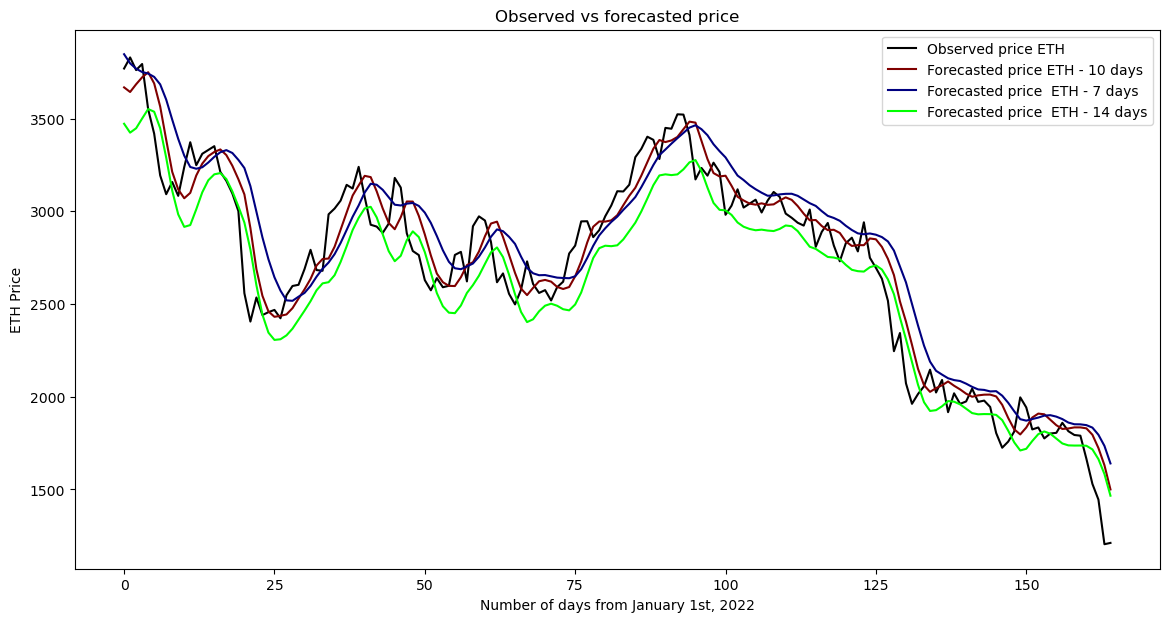

<Figure size 640x480 with 0 Axes>

In [77]:
plt.figure(figsize = (14,7))
plt.plot(actual_prices, color='black', label= f"Observed price {crypto}")
plt.plot(predicted_prices5, color='maroon',label = f"Forecasted price {crypto} - 10 days")
plt.plot(predicted_prices5_7, color='navy',label = f"Forecasted price  {crypto} - 7 days")
plt.plot(predicted_prices5_14, color='lime',label = f"Forecasted price  {crypto} - 14 days")
plt.title("Observed vs forecasted price")
plt.xlabel('Number of days from January 1st, 2022')
plt.ylabel(f'{crypto} Price')
plt.legend(loc='upper right')
plt.show();
plt.savefig('comparison.png');

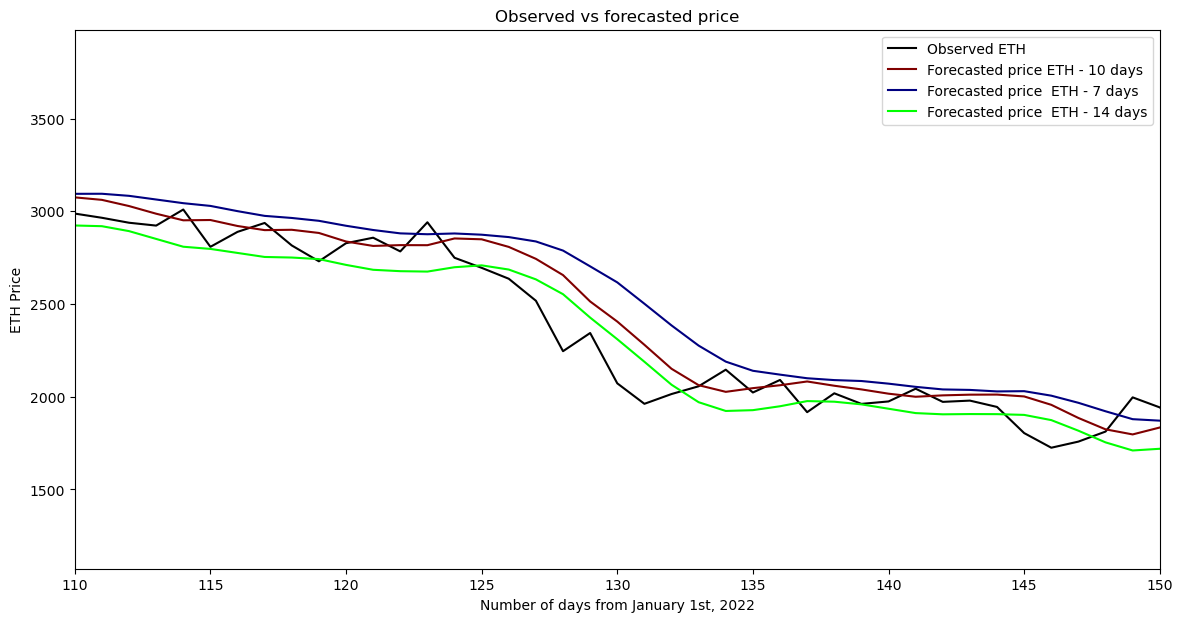

<Figure size 640x480 with 0 Axes>

In [78]:
plt.figure(figsize = (14,7))
plt.plot(actual_prices, color='black', label= f"Observed {crypto}")
plt.plot(predicted_prices5, color='maroon',label = f"Forecasted price {crypto} - 10 days")
plt.plot(predicted_prices5_7, color='navy',label = f"Forecasted price  {crypto} - 7 days")
plt.plot(predicted_prices5_14, color='lime',label = f"Forecasted price  {crypto} - 14 days")
plt.title("Observed vs forecasted price")
plt.xlabel('Number of days from January 1st, 2022')
plt.ylabel(f'{crypto} Price')
plt.xlim([110,150])
plt.legend(loc='upper right')
plt.show();
plt.savefig('detailed_comparison.png');

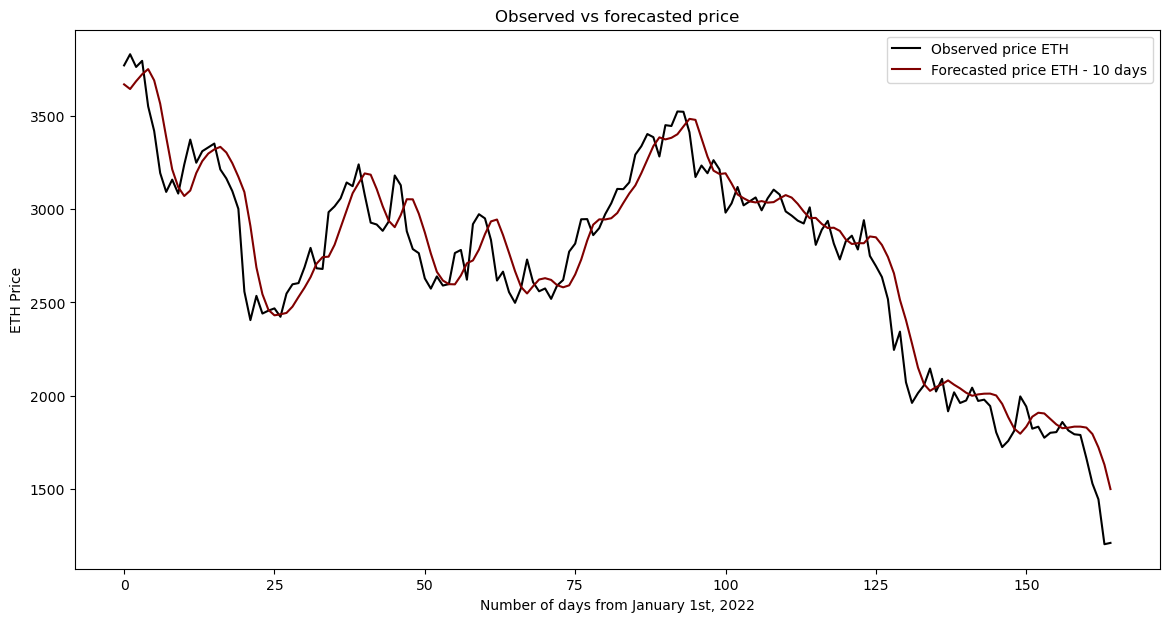

<Figure size 640x480 with 0 Axes>

In [79]:
plt.figure(figsize = (14,7))
plt.plot(actual_prices, color='black', label= f"Observed price {crypto}")
plt.plot(predicted_prices5, color='maroon',label = f"Forecasted price {crypto} - 10 days")
plt.title("Observed vs forecasted price")
plt.xlabel('Number of days from January 1st, 2022')
plt.ylabel(f'{crypto} Price')
plt.legend(loc='upper right')
plt.show();
plt.savefig('compare_1model.png');

In [80]:
test_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-01 00:00:00+00:00,3683.047119,3769.917969,3682.286621,3769.697021,9776191466,0.0,0.0
2022-01-02 00:00:00+00:00,3769.298340,3836.161865,3727.357422,3829.564941,9881471548,0.0,0.0
2022-01-03 00:00:00+00:00,3829.535645,3836.198730,3698.047607,3761.380371,12080777893,0.0,0.0
2022-01-04 00:00:00+00:00,3761.361572,3876.785156,3723.349854,3794.056641,14030925983,0.0,0.0
2022-01-05 00:00:00+00:00,3794.269043,3842.059814,3456.745361,3550.386963,18061338502,0.0,0.0


In [81]:
test_data['Forecast'] = predicted_prices8
test_data.index = test_data.index.tz_localize(None)
test_data[['Close','Forecast']].to_excel('results.xlsx')

### Returns plot

In [82]:
forecast = pd.read_excel("results.xlsx")
forecast.head()

,Date,Close,Forecast
0,2022-01-01,3769.697021,3633.620361
1,2022-01-02,3829.564941,3599.198730
2,2022-01-03,3761.380371,3570.875732
3,2022-01-04,3794.056641,3541.053711
4,2022-01-05,3550.386963,3518.895996


In [83]:
forecast.set_index("Date", inplace = True)

In [84]:
forecast['Actual_return'] = forecast.Close.pct_change()
forecast['Forecasted_return'] = forecast.Forecast.pct_change()

/var/folders/xh/5lg9qcnx25b4hk8z8j66l_r80000gn/T/ipykernel_38147/1967349326.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


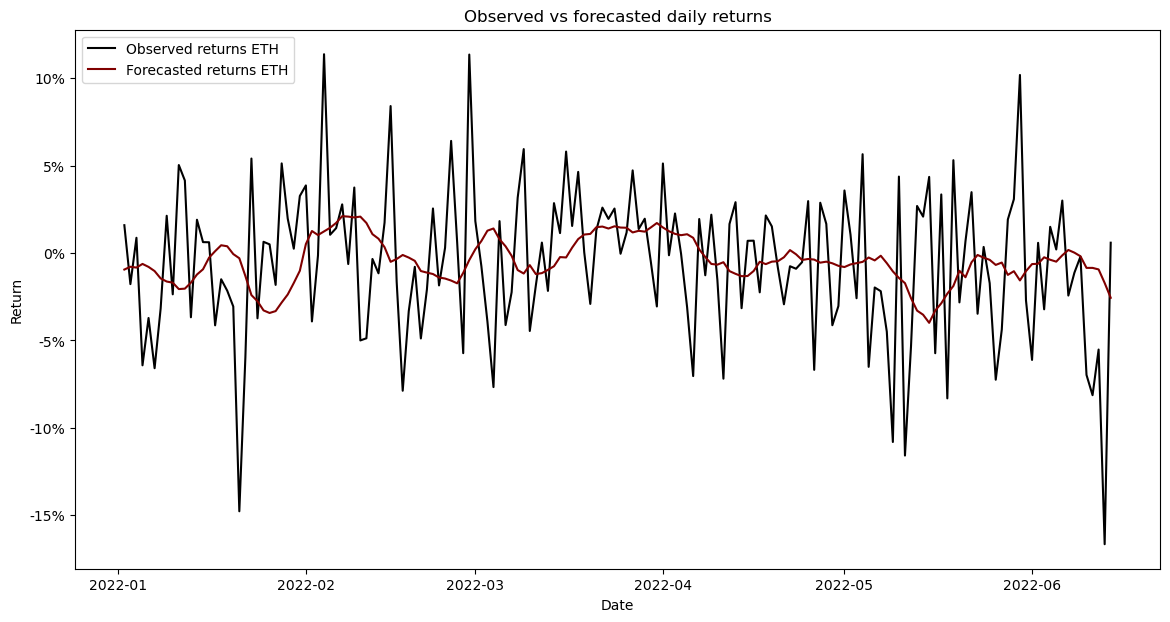

In [85]:
plt.figure(figsize = (14,7))
plt.plot(forecast['Actual_return'], color='black', label= f"Observed returns {crypto}")
plt.plot(forecast['Forecasted_return'], color='maroon',label = f"Forecasted returns {crypto}")
plt.title("Observed vs forecasted daily returns")
plt.xlabel('Date')
plt.ylabel('Return')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.legend(loc='upper left')
plt.show();